<a href="https://colab.research.google.com/github/alxgrin/kaggle/blob/main/c/cassava-leaf-disease-classification/cassava_leaf_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cassava Leaf Disease Classification

Identify the type of disease present on a Cassava Leaf image

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Recommended Tutorial**
We highly recommend [Jesse Mostipak’s Getting Started Tutorial](https://www.kaggle.com/jessemostipak/getting-started-tpus-cassava-leaf-disease) that walks you through making your very first submission step by step.

Link: https://www.kaggle.com/c/cassava-leaf-disease-classification/overview

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from skimage import io
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_PATH = "/content/drive/MyDrive/kaggle_data/c_cassava-leaf-disease-classification"
!ls $DATA_PATH

label_num_to_disease_map.json  test_images     train.csv     train_tfrecords
sample_submission.csv	       test_tfrecords  train_images


In [4]:
train_df = pd.read_csv(DATA_PATH + "/train.csv", index_col="image_id")
train_df

,label
image_id,
1000015157.jpg,0
1000201771.jpg,3
100042118.jpg,1
1000723321.jpg,1
1000812911.jpg,3
...,...
999068805.jpg,3
999329392.jpg,3
999474432.jpg,1


In [5]:
train_df.value_counts()

label
3        13158
4         2577
2         2386
1         2189
0         1087
dtype: int64

In [6]:
labels = pd.read_json(DATA_PATH + "/label_num_to_disease_map.json", orient="index")
labels

,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


## Загрузка и первичная обработка файлов

In [7]:
class CassavaDataset(Dataset):
    """
    see: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files
    """

    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cassava_frame = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.cassava_frame)

    def __getitem__(self, idx):
        image_id, label = self.cassava_frame.iloc[idx]

        image = io.imread(os.path.join(self.image_dir, image_id))
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
tfs = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize([512, 512]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

train_dataset = CassavaDataset(
    csv_file=DATA_PATH + "/train.csv",
    image_dir=DATA_PATH + "/train_images",
    transform=tfs,
)
len(train_dataset)

21397

In [9]:
# indices = np.random.choice(len(train_dataset), 1536)
# subtrain_dataset = torch.utils.data.Subset(train_dataset, indices)
# len(subtrain_dataset)

In [10]:
# https://medium.com/jun-devpblog/pytorch-1-transform-imagefolder-dataloader-7f75f0a460c0

BATCH_SIZE = 8

total_count = len(train_dataset)
train_count, val_count = int(0.7 * total_count), int(0.2 * total_count)
test_count = total_count - (train_count + val_count)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, (train_count, val_count, test_count)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

train_count, val_count, test_count

(14977, 4279, 2141)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


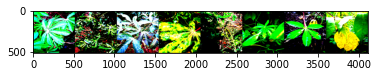

In [11]:
# https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2
# .. https://stackoverflow.com/a/51331557
images, labels = next(iter(train_loader))

grid_img = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(grid_img.permute(1, 2, 0))

In [12]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

## Подготовка и обучение модели

In [13]:
# https://www.kaggle.com/japandata509/ensemble-resnext50-32x4d-efficientnet-0-903


class CassavaClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # https://pytorch.org/vision/stable/models.html#classification
        # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
        self.model = models.resnet50()
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 5)

    def forward(self, x):
        x = self.model(x)
        return x

In [14]:
model = CassavaClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=1e-4, max_lr=1e-3, cycle_momentum=False
)

In [15]:
def accuracy_score(model, loader, desc=""):
    model.eval()

    accuracy_score = 0

    pbar = tqdm(enumerate(loader), total=len(loader))
    if desc:
        pbar.set_description(desc)

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        accuracy = (y_preds.argmax(dim=1) == labels).float().mean()
        accuracy_score += accuracy.cpu().detach().numpy()

    return accuracy_score / len(loader)

In [16]:
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# .. https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug
# .. https://www.kaggle.com/abhinand05/vision-transformer-vit-tutorial-baseline?scriptVersionId=48380283&cellId=21

num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    pbar.set_description("Epoch: %d" % epoch)

    epoch_loss = 0
    epoch_accuracy = 0

    for _, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device).long()

        y_preds = model(images)
        loss = loss_fn(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (y_preds.argmax(dim=1) == labels).float().mean()

        epoch_loss += loss.cpu().detach().numpy()
        epoch_accuracy += accuracy.cpu().detach().numpy()

    scheduler.step()

    print(
        "Loss: {}, Train accuracy: {}, Val accuracy: {}".format(
            epoch_loss / len(train_loader),
            epoch_accuracy / len(train_loader),
            accuracy_score(model, val_loader, "Validate accuracy"),
        )
    )

  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 1.1097986172433212, Train accuracy: 0.6199279231179925, Val accuracy: 0.6504339120098364


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.9849420754876419, Train accuracy: 0.6408836091831287, Val accuracy: 0.6673898532011798


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.8896334273288165, Train accuracy: 0.6655098772023492, Val accuracy: 0.697496662240162


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.8108879012486798, Train accuracy: 0.6947410571276028, Val accuracy: 0.668624833142646


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.7674545761430511, Train accuracy: 0.7091564335290977, Val accuracy: 0.6975300401170678


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.7161049054357786, Train accuracy: 0.737386545648692, Val accuracy: 0.7473297730784549


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.6650695121835657, Train accuracy: 0.7550053390282968, Val accuracy: 0.7317757009345794


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.6255221779588004, Train accuracy: 0.7730245595301655, Val accuracy: 0.7609145527688143


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.5824344625275878, Train accuracy: 0.788240790176188, Val accuracy: 0.7723965288322663


  0%|          | 0/1873 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

Loss: 0.5364631646697137, Train accuracy: 0.8029231179925254, Val accuracy: 0.7320093457943925


## Проверка результатов

In [17]:
test_accuracy = accuracy_score(model, test_loader, "Test accuracy")
test_accuracy

  0%|          | 0/268 [00:00<?, ?it/s]

0.742070895522388